# Transfer Learning with PyTorch

In this notebook, I will show you how to use transfer learning to train a model on a dataset that is different from the one it was originally trained on. 

- Foundataion Model: VGG16
- Original Dataset: ImageNet
- New Dataset: Cats vs Dogs

# Download Dataset

Download Cat Dog dataset from [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765) and extract it to the current directory.

In [57]:
# download the zip file via url and save it as cats_dogs_dataset.zip
!wget -O cats_dogs_dataset.zip https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2024-08-21 01:25:42--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 2001:b034:b02:185::317f, 2001:b034:b02:1ab::317f, 163.28.224.206
Connecting to download.microsoft.com (download.microsoft.com)|2001:b034:b02:185::317f|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘cats_dogs_dataset.zip’

cats_dogs_dataset.z 100%[===================>] 786.67M   109MB/s    in 7.2s    

2024-08-21 01:25:49 (109 MB/s) - ‘cats_dogs_dataset.zip’ saved [824887076/824887076]



In [58]:
import os

# unzip the file
if not os.path.exists('PetImages'):
    !unzip -q cats_dogs_dataset.zip
    print('Dataset downloaded and extracted')
else:
    print('Dataset already downloaded and extracted')

Dataset already downloaded and extracted


# Download the package

In [59]:
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Visualize the data

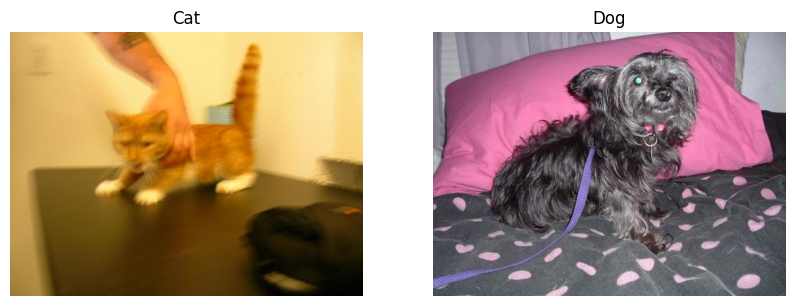

In [60]:
import matplotlib.pyplot as plt
import PIL

cat_img_path = './PetImages/Cat/0.jpg'
dog_img_path = './PetImages/Dog/0.jpg'

cat_img = PIL.Image.open(cat_img_path)
dog_img = PIL.Image.open(dog_img_path)

plt.figure(figsize=(10, 5))
# Cat
plt.subplot(1, 2, 1)
plt.imshow(cat_img)
plt.title('Cat')
plt.axis('off')
# Dog
plt.subplot(1, 2, 2)
plt.imshow(dog_img)
plt.title('Dog')
plt.axis('off')
plt.show()

# Create Dataset and DataLoader

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

In [62]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [63]:
dataset = datasets.ImageFolder(root='PetImages', transform=transform)

In [64]:
print(f"Number of images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")
# show the len of each class
print(f"Dataset distribution:")
print(f"{dataset.classes[0]}: {dataset.targets.count(0)}")
print(f"{dataset.classes[1]}: {dataset.targets.count(1)}")

Number of images: 25000
Number of classes: 2
Classes: ['Cat', 'Dog']
Dataset distribution:
Cat: 12500
Dog: 12500


In [65]:
# split the dataset into train, val, test (70%, 20%, 10%)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 17500
Validation dataset size: 5000
Test dataset size: 2500


In [66]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

# Import Foundation Model

VGG16(Very Deep Convolutional Network)

Model Structure:
- 13 convolutional layers
- 3 fully connected layers
- 5 max pooling layers

![VGG16](./src/VGG16.png)

In [67]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [68]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

# Load the pre-trained model
model = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)

In [69]:
# show the model architecture
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Hyperparameters

In [70]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 2

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and Validate

In [71]:
train_accuracy, train_loss = [], []
val_accuracy, val_loss = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f'Epoch {epoch+1}/{num_epochs}')
    for idx, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        # accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy.append(100 * correct / total)
    train_loss.append(running_loss / total)

    print(f'Training Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1]:.2f}%')
    
    # Validation
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # loss
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            # accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct / total)
    val_loss.append(running_loss / total)

    print(f'Validation Loss: {val_loss[-1]:.4f}, Accuracy: {val_accuracy[-1]:.2f}%')

# Assignments

1. train a classifier based on other pre-trained models
2. at least surpass 90% accuracy on the test set

Tips to improve the performance:
- Configure the hyperparameters such as learning rate, batch size, number of epochs, etc.
- Data Augmentation such as random crop, random flip, etc.

you can use pre-trained models such as:
- AlexNet
- VGG19
- ResNet18
- ResNet50

check the [torchvision.models](https://pytorch.org/vision/stable/models.html#classification) for more details.

<img src="./src/pre-trained_model.jpg" width="400">